In [1]:
# Install necessary libraries
!pip install tensorflow keras opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.9 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
# Import required libraries
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

2024-04-17 07:49:55.873655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 07:49:55.873775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 07:49:56.008419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_images(directory, size=(256, 256)):
    images = []
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        img = load_img(img_path, target_size=size)
        img = img_to_array(img)
        images.append(img)
    return images

In [4]:
train_high_dir = "/kaggle/input/lol-dataset/lol_dataset/our485/high"
train_low_dir = "/kaggle/input/lol-dataset/lol_dataset/our485/low"

test_high_dir = "/kaggle/input/lol-dataset/lol_dataset/eval15/high"
test_low_dir = "/kaggle/input/lol-dataset/lol_dataset/eval15/low"

train_high = load_images(train_high_dir)
train_low = load_images(train_low_dir)
test_high = load_images(test_high_dir)
test_low = load_images(test_low_dir)

In [ ]:
print("Training low images shape:", np.array(train_low).shape)
print("Training high images shape:", np.array(train_high).shape)
print("Testing low images shape:", np.array(test_low).shape)
print("Testing high images shape:", np.array(test_high).shape)


# Model

In [6]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_autoencoder():
    input_img = Input(shape=(256, 256, 3))

    # Encoder
    x1 = Conv2D(64, (3, 3), padding='same')(input_img)
    x1 = LeakyReLU(alpha=0.2)(x1)
    p1 = MaxPooling2D((2, 2), padding='same')(x1)  # Downsampling to 128x128
    
    x2 = Conv2D(128, (3, 3), padding='same')(p1)
    x2 = LeakyReLU(alpha=0.2)(x2)
    p2 = MaxPooling2D((2, 2), padding='same')(x2)  # Downsampling to 64x64

    # Bottleneck
    b = Conv2D(256, (3, 3), padding='same')(p2)
    b = LeakyReLU(alpha=0.2)(b)  # Still 64x64

    # Decoder
    x2 = UpSampling2D((2, 2))(b)  # Upsample to 128x128
    x2 = Conv2D(128, (3, 3), padding='same')(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    #x2 = concatenate([x2, p2])  # If you need a skip connection, make sure dimensions match.

    x1 = UpSampling2D((2, 2))(x2)  # Upsample to 256x256
    x1 = Conv2D(64, (3, 3), padding='same')(x1)
    x1 = LeakyReLU(alpha=0.2)(x1)
    #x1 = concatenate([x1, p1])  # If you need a skip connection, make sure dimensions match.

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                             

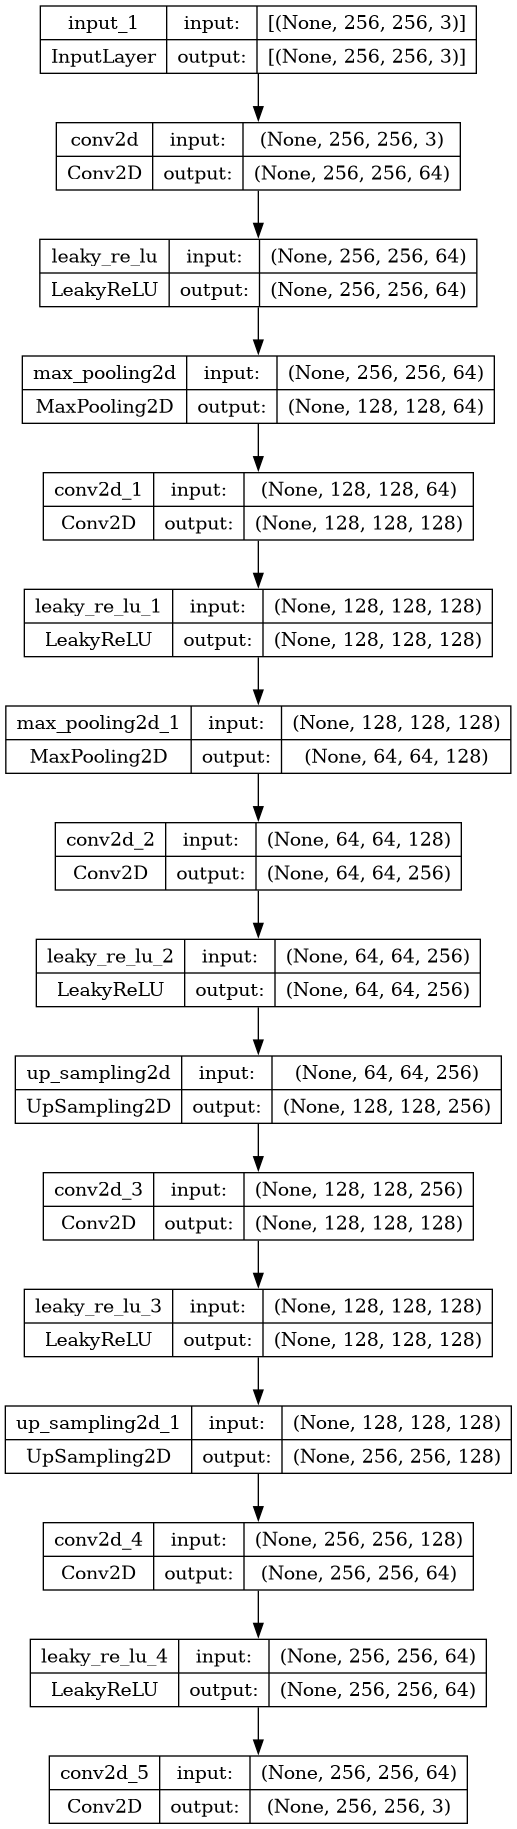

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
plot_model(autoencoder,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import MeanSquaredError

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, input_shape=(256, 256, 3))
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    model.trainable = False

    return MeanSquaredError()(model(y_true), model(y_pred))

autoencoder.compile(optimizer='adam', loss=perceptual_loss)

In [9]:
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')


In [10]:
train_low = np.array(train_low) / 255.0
train_high = np.array(train_high) / 255.0
test_low = np.array(test_low) / 255.0
test_high = np.array(test_high) / 255.0

In [61]:
autoencoder.fit(train_low, train_high, epochs=10, batch_size=50, verbose = 1, steps_per_epoch=250, validation_data=(test_low, test_high), shuffle=True)

Epoch 1/10
250/250 [==============================] - 81s 240ms/step - loss: 0.0194 - val_loss: 0.0200


In [62]:
predicted = autoencoder.predict(test_low)

1/1 [==============================] - 0s 34ms/step


In [63]:
import matplotlib.pyplot as plt

# Visualization function modified to show three images (original, ground truth, and predicted)
def plot_images(original, ground_truth, predicted):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original Image', color = 'green', fontsize = 10)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted)
    plt.title('Enhanced ', color = 'Red', fontsize = 10)
    plt.axis('off')

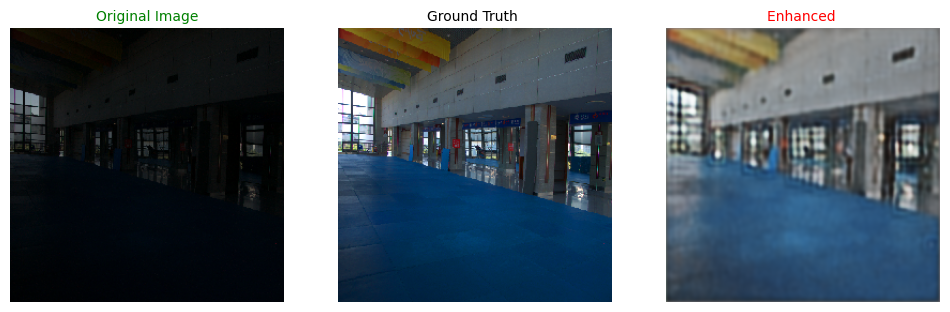

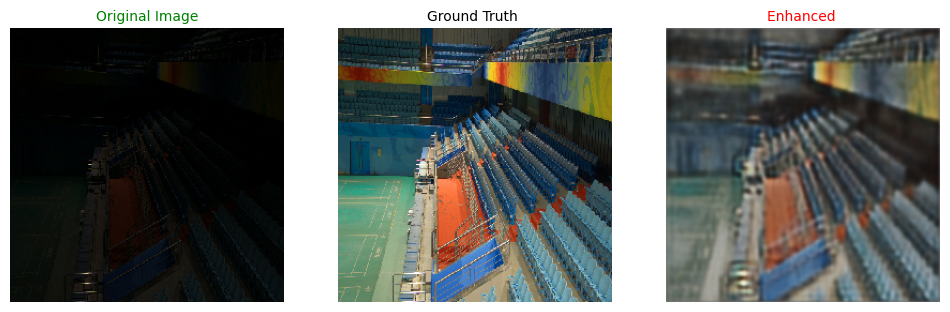

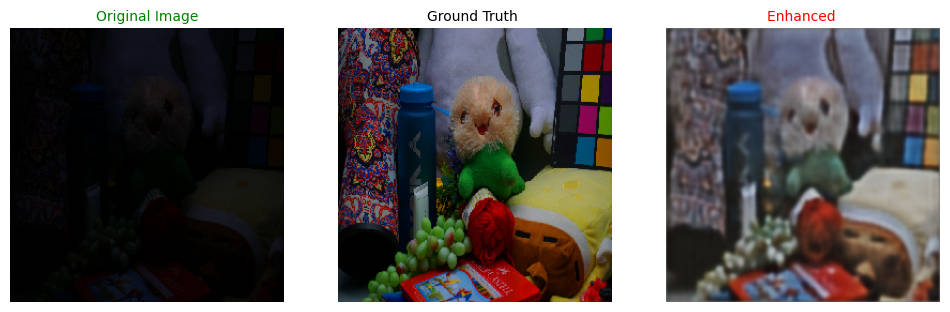

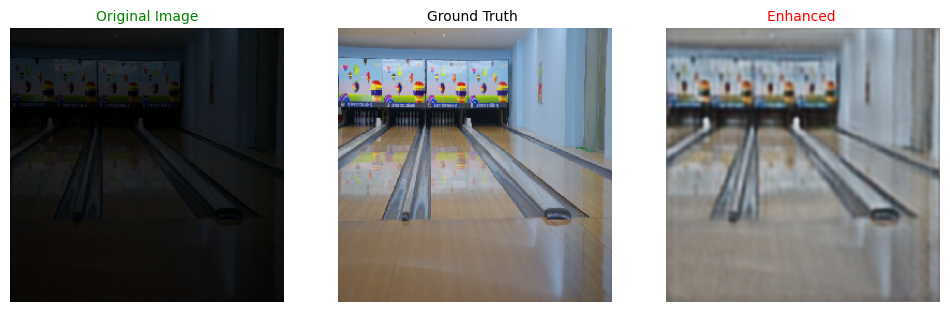

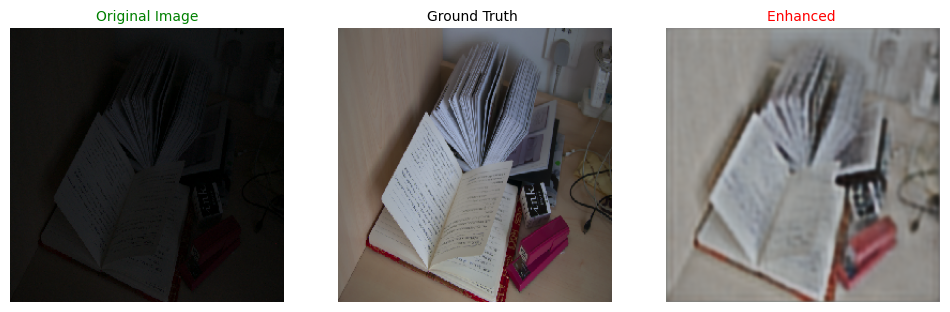

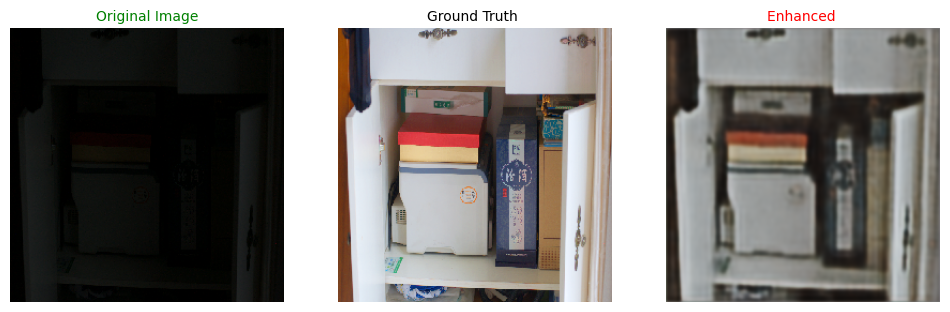

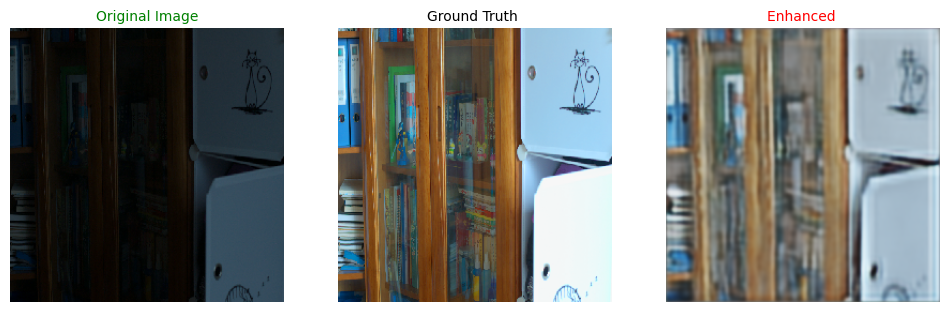

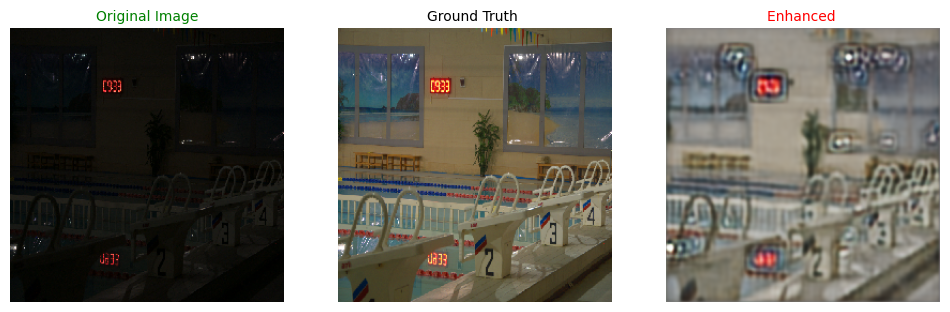

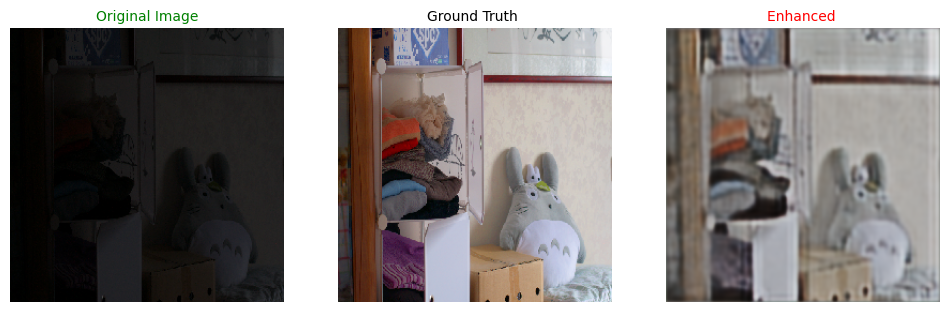

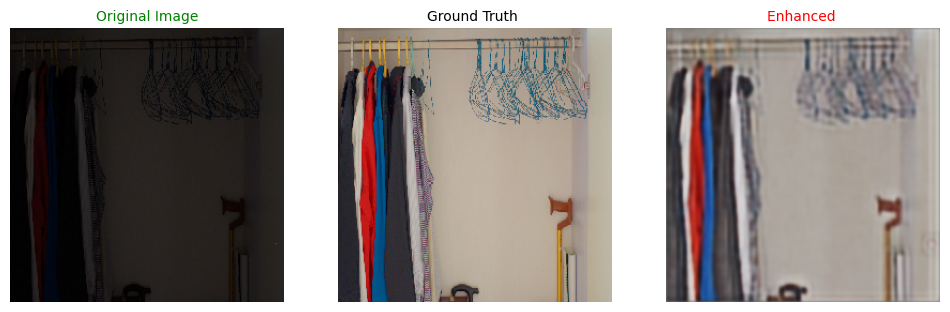

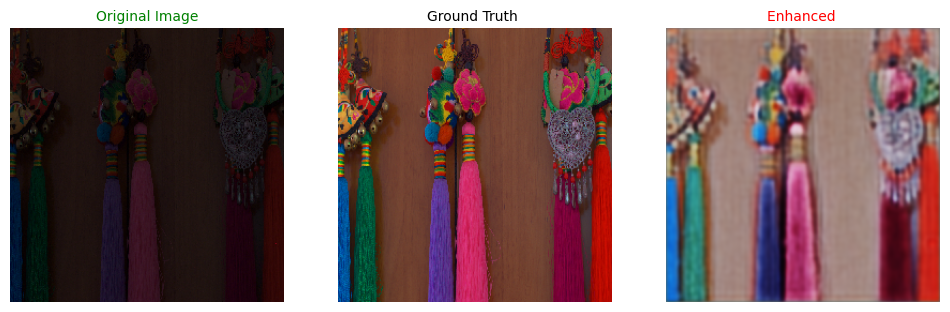

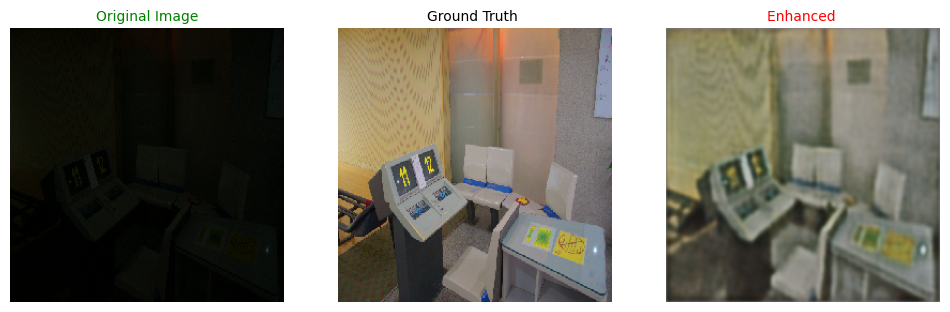

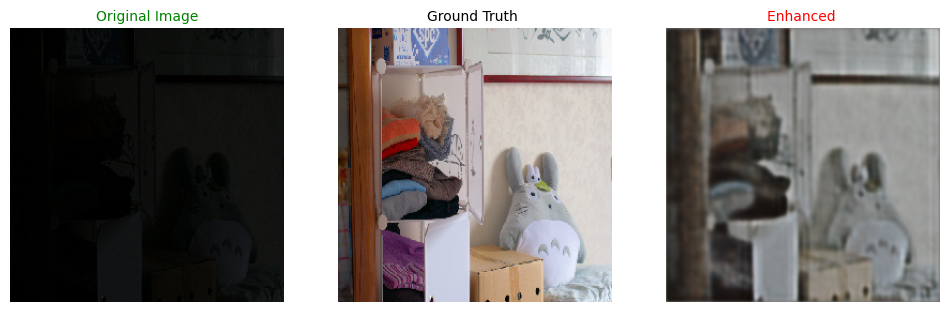

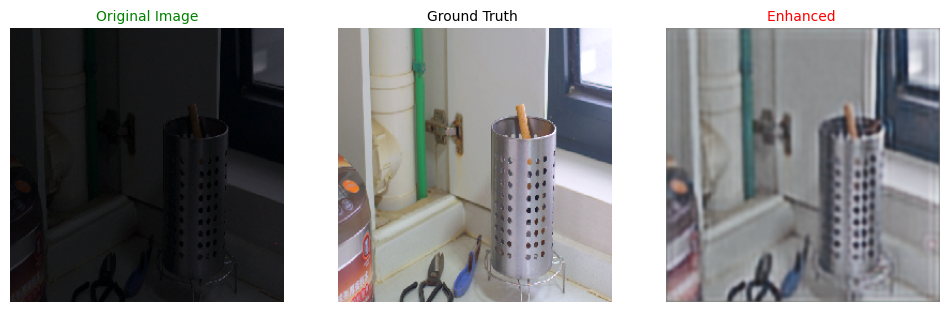

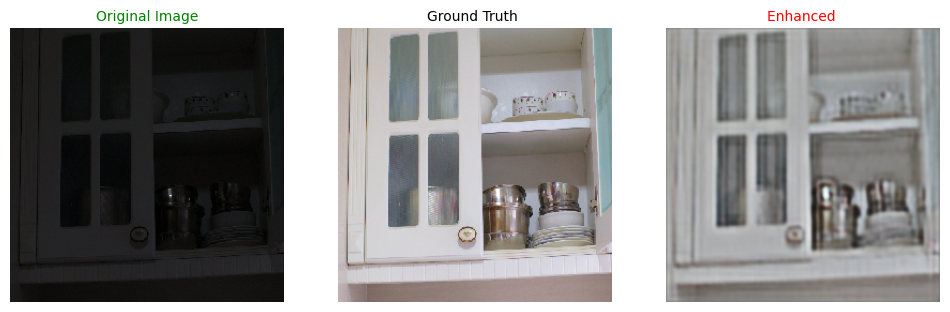

In [64]:
for original, truth, pred in zip(test_low, test_high, predicted):
    plot_images(original, truth, pred)

In [65]:
from tensorflow.keras.metrics import MeanSquaredError

def mse(target, prediction):
    mse_calculator = MeanSquaredError()
    mse_calculator.update_state(target, prediction)
    return mse_calculator.result().numpy()

def psnr(target, prediction, max_pixel=1.0):
    mse_value = mse(target, prediction)
    if mse_value == 0:
        return 100
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

In [66]:
test_mse = mse(test_high, predicted)
test_psnr = psnr(test_high, predicted)

print("Mean Squared Error on Test Set:", test_mse)
print("Peak Signal-to-Noise Ratio on Test Set:", test_psnr)


Mean Squared Error on Test Set: 0.019985389
Peak Signal-to-Noise Ratio on Test Set: 16.9928741613071


In [17]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Evaluation
for i in range(len(test_low)):
    print(f"PSNR: {psnr(test_high[i], predicted[i])}")

PSNR: 14.12843405071751
PSNR: 17.99982253271044
PSNR: 15.441061428436543
PSNR: 20.374986721913608
PSNR: 16.19235146511929
PSNR: 13.453975469447606
PSNR: 14.89248599230493
PSNR: 16.30743068085141
PSNR: 17.397507551985388
PSNR: 19.60688036680952
PSNR: 12.517778370401135
PSNR: 21.647952883600745
PSNR: 13.766117372846123
PSNR: 18.900044596982106
PSNR: 17.707095399245652
